# Probabilistic solvers as collocation methods

Probabilistic solvers condition a prior distribution on satisfying an ODE on a specified grid.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import controls, dense_output, solution_routines, solvers
from probdiffeq.implementations import recipes
from probdiffeq.strategies import smoothers

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax


config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [2]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.affine_independent()
f_vect = jax.vmap(f, in_axes=(0, None, None))


@jax.jit
def vector_field(y, *, t, p):
    return f(y, *p)


# Make a solver
solver = solvers.MLESolver(
    smoothers.Smoother(recipes.DenseSLR1.from_params(ode_shape=(1,), num_derivatives=1))
)

In [3]:
%%time

# Solve the ODE with low precision
solution = solution_routines.solve_with_python_while_loop(
    vector_field,
    initial_values=(u0[None],),
    t0=t0,
    t1=t1,
    rtol=1e-2,
    solver=solver,
    parameters=f_args,
    control=controls.IntegralClipped(),
)

CPU times: user 1.57 s, sys: 34.8 ms, total: 1.6 s
Wall time: 1.58 s


In [4]:
# Evalate the posterior on a dense grid

eps = 1e-4
mesh = jnp.linspace(t0 + eps, t1 - eps, num=50, endpoint=True)
_, marginals = dense_output.offgrid_marginals_searchsorted(
    ts=mesh, solution=solution, solver=solver
)

posterior_u = marginals.marginal_nth_derivative(0).mean
posterior_du = marginals.marginal_nth_derivative(1).mean

In [5]:
# Extrapolate the prior on the dense grid

extrapolation_model = solver.strategy.implementation.extrapolation
taylor_coefficients = jnp.reshape(
    solution.marginals.hidden_state.mean[0, ...],
    solution.marginals.target_shape,
    order="F",
)


@jax.jit
def extrapolate_fn(rv, model, dt, scale_sqrtm):
    ssv, cache = model.begin_extrapolation(rv, dt)
    rv = model.complete_extrapolation(
        ssv, p0=rv, cache=cache, output_scale_sqrtm=scale_sqrtm
    )
    return rv


prior_u = []
prior_du = []
rv = extrapolation_model.init_corrected(taylor_coefficients)
for t_old, t_new in zip(mesh[:-1], mesh[1:]):
    prior_u.append(rv.marginal_nth_derivative(0).mean)
    prior_du.append(rv.marginal_nth_derivative(1).mean)

    dt = t_new - t_old
    rv = extrapolate_fn(rv, extrapolation_model, dt, solution.output_scale_sqrtm.mean())

prior_u.append(rv.marginal_nth_derivative(0).mean)
prior_du.append(rv.marginal_nth_derivative(1).mean)

prior_u = jnp.asarray(prior_u)
prior_du = jnp.asarray(prior_du)

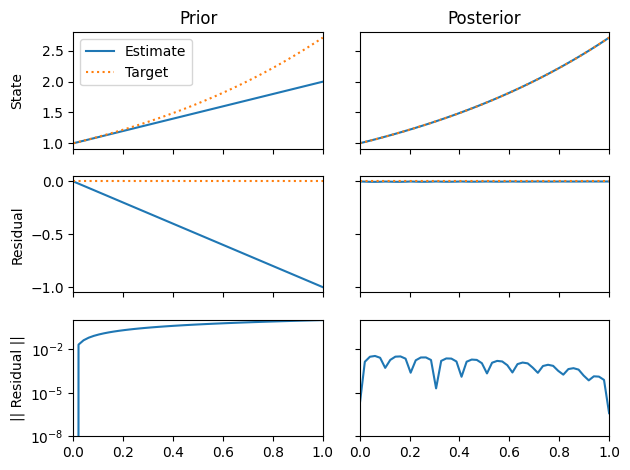

In [6]:
# Plot the samples

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey="row")
((ax0, ax1), (ax2, ax3), (ax4, ax5)) = axes


ax0.set_title("Prior")
ax1.set_title("Posterior")

ax0.set_ylabel("State")
ax2.set_ylabel("Residual")
ax4.set_ylabel("|| Residual ||")


ax0.plot(mesh, prior_u, label="Estimate")
ax0.plot(mesh, posterior_u, linestyle="dotted", color="C1", label="Target")
ax1.plot(mesh, posterior_u)
ax1.plot(mesh, posterior_u, linestyle="dotted", color="C1")

ax2.plot(mesh, prior_du - f_vect(prior_u, *f_args))
ax2.axhline(0.0, linestyle="dotted", color="C1")
ax3.plot(mesh, posterior_du - f_vect(posterior_u, *f_args))
ax3.axhline(0.0, linestyle="dotted", color="C1")

# clip = 1e-8
clip = 0.0
ax4.semilogy(mesh, jnp.abs(prior_du - f_vect(prior_u, *f_args)) + clip)
ax5.semilogy(mesh, jnp.abs(posterior_du - f_vect(posterior_u, *f_args)) + clip)
ax4.axhline(clip, linestyle="dotted", color="C1")
ax5.axhline(clip, linestyle="dotted", color="C1")
ax4.set_ylim((1e-8, 1e0))
ax5.set_ylim((1e-8, 1e0))
# for t in solution.t:
#     ax5.axvline(t, linestyle="dotted")

# for ax in (ax2, ax3, ax4, ax5):
#     ax.axhline(0., linestyle="dotted")


ax0.set_xlim((t0, t1))
# ax0.set_ylim((-20, 40))
# ax2.set_ylim((-100, 100))
ax0.legend()
plt.tight_layout()
fig.align_ylabels()
# plt.savefig("Figure.pdf")
plt.show()

The prior state estimate (top left) has a large residual $\dot u - f(u)$. By conditioning on satisfying a zero residual (bottom left to bottom right), the state estimate becomes a useful ODE solution (top right).